# ML model for January
Splitting based on spatial distribution

## Import libraries

In [79]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import plotly
from scipy.stats import gaussian_kde
import geopandas as gpd
from shapely.geometry import Point
from scipy.special import inv_boxcox


## Load the data

In [80]:
# import the previously saved stations data to the notebook

final_df_jan_new = None
with open("final_df_jan_new", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    final_df_jan_new = pickle.load(file)

# Load the shapefile for Bavaria
shapefile_path = r"H:\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

In [81]:
with open("lambda_boxcox", 'rb') as file:
    lambda_boxcox = pickle.load(file)

In [82]:
final_df_jan_new

,NO3-N [mg/l],NO3-N [mg/l] BC,station_name,station_number,water_body,lat,lon,slope_avg,elev_avg,lc_avg_01,...,soil_avg_04,soil_avg_05,soil_avg_06,soil_avg_07,soil_avg_08,soil_avg_09,soil_avg_10,tmin_avg_1,tmax_avg_1,prec_sum_1
0,6.162333,2.671989,"Strbr. in Höhe v. Stein, obh. KA",13516,Ölschnitz,50.062500,11.704167,216.0,584.0,15.0,...,36.0,16.0,15.0,18.0,1236.0,240.0,3.0,-43.0,7.0,9312.0
1,4.294000,1.977289,Str.br.von Neundorf nach Bächlein,15123,Föritz,50.254167,11.212500,240.0,381.0,22.0,...,36.0,12.0,14.0,19.0,1287.0,240.0,4.0,-40.0,12.0,1744.0
2,8.701000,3.437690,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,49.987500,9.979167,118.0,303.0,0.0,...,43.0,23.0,8.0,24.0,1282.0,236.0,8.0,-34.0,19.0,5427.0
3,3.446500,1.589518,Strbr. Oberteich,23397,Seibertsbach,49.937500,12.212500,190.0,589.0,23.0,...,38.0,15.0,17.0,23.0,1215.0,240.0,6.0,-53.0,0.0,2992.0
4,3.465333,1.607559,Straßenbr zum KW Oberelchingen,42442,Leibi,48.437500,10.104167,224.0,745.0,6.0,...,39.0,19.0,12.0,24.0,1269.0,234.0,7.0,-46.0,15.0,904499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,7.910000,3.215839,800m uh. Wenigrötz,105645,Rötzerbach,49.329167,12.387500,148.0,476.0,1.0,...,38.0,16.0,16.0,14.0,1293.0,240.0,5.0,-53.0,1.0,2828.0
486,0.625000,-0.434500,800m oh nordwestl Ammeraltwasser,113898,Waizackerbach,47.862500,11.129167,433.0,875.0,20.0,...,37.0,17.0,12.0,27.0,1260.0,230.0,8.0,-50.0,18.0,62210.0
487,4.520000,2.064355,200m u.h. Bahnl. Markt Schwaben,130316,Forstinninger Sempt,48.212500,11.887500,49.0,544.0,19.0,...,38.0,16.0,10.0,22.0,1305.0,240.0,2.0,-56.0,10.0,16145.0
488,5.574667,2.456450,700m oh Mündung in Ach,136340,Dinkelshausener Arrondierungskanal,48.645833,11.170833,96.0,417.0,3.0,...,37.0,17.0,9.0,20.0,1247.0,240.0,3.0,-40.0,15.0,10393.0


## Defining functions

In [83]:
def split_with_spatial_dist(dataframe, bandwidth, train_ratio, block_size, random_seed = None ):
    """
        Splits the given dataset into training and testing sets, maintaining similar spatial distribution in both sets. 
        Uses a gaussian kernel desnsity estimation technique to calculate probabilty density of monitoring stations' location. 
        Using the probabilty density, assigns weights to stations and uses these weights to split the stations into training and testing sets. 
        Note: depending on the user, the dataframe might be different. Hence certain sections of this function might need to be edited depending on 
        the structure of your dataframe. 
        Author: Karan Mahajan, Technical University of Munich, karanmahajan.chd@gmail.com
    Args:
        dataframe (pandas dataframe): The data file with the station latitude and longitude columns
        bandwith (int): Bandwith in kilometer for the kernel density estimation technique
        train_ratio (float): proportion of data to be included in the training set. Recommended is 0.8 
        block_size (int): the size of individual blocks of density values out of which user wants to sample data for testing and training sets.
        random_seed (int): to ensure that results can be reproduces. If not specified, we'll get a different split everytime the function is run. 

    Returns:
        kde: kernel density estimate, that is fitted using the coordinate data
        sorted_df: dataframe sorted according to the density weights (ascending order). The X data in this dataframe is scaled using standard scaler.
        train_ind: indices from sorted_df that go into training set
        test_ind: indices from sorted_df that go into testing set
        scaler: the  scaler used to scale the data
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    train_ind = []
    test_ind = []
    
    # Set the bandwidth in degrees (approximation: 1 degree latitude ≈ 111 km)
    bandwidth_deg = round(bandwidth / 111, 2)  # Convert 50 km to degrees
    
    # Generate the Gaussian Kernel Density Estimate
    xy = np.vstack([dataframe['lon'], dataframe['lat']])
    kde = gaussian_kde(xy, bw_method=bandwidth_deg)

    # Evaluate KDE only over the station points
    density_weights = kde(np.vstack([dataframe['lon'], dataframe['lat']]))

    test_df = final_df_jan_new.copy()

    # Add desnity_weights to the dataframe at a specific column index (better for visualisation)
    test_df['density_val'] = density_weights
    col_order = test_df.columns.tolist()
    col_order.insert(7, col_order[-1])
    col_order.pop(-1)
    test_df = test_df[col_order]

    # Scale the independent variables or features and add them back to the dataframe
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(test_df.iloc[:, 8:])
    scaled_df = pd.DataFrame(scaled_features, index=test_df.index, columns=test_df.columns[8:])
    scaled_df = scaled_df.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match

    # Replace the original data with the scaled data
    test_df.iloc[:, 8:] = scaled_df


    sorted_df = test_df.sort_values(by='density_val').reset_index(drop=True)

    # Loop through sorted_df in blocks of block_size, and then randomly sample train_ratio*10 samples for training and remaining for testing
    for i in range(0, len(sorted_df),block_size):
        block_indices = list(range(i,min(len(sorted_df), i+block_size)))
        np.random.shuffle(block_indices)
        num_train_block = int(train_ratio*10)
        train_indices_block = block_indices[:num_train_block]
        test_indices_block = block_indices[num_train_block:]

        train_ind.extend(train_indices_block)
        test_ind.extend(test_indices_block)

        np.random.shuffle(train_ind)
        np.random.shuffle(test_ind)


    return kde, sorted_df, train_ind, test_ind, scaler

def data_from_spatial_split(sorted_df, train_ind, test_ind):
    y_train = sorted_df.iloc[train_ind, 1]  # Assuming the target variable is at index 1
    X_train = sorted_df.iloc[train_ind, 8:]  # Assuming features start from index 8

    y_test = sorted_df.iloc[test_ind, 1]
    X_test = sorted_df.iloc[test_ind, 8:]

    return X_train, X_test, y_train, y_test


def pearson_corr_coeff(X,y):
    X_bar = np.mean(X)
    y_bar = np.mean(y)
    numr = np.sum((X-X_bar)*(y-y_bar))
    denmr = np.sqrt(np.sum(np.square(X-X_bar)*np.sum(np.square(y-y_bar))))
    r = numr/denmr
    return r

In [84]:
# Implement the function to get the training and testing data

kde, sorted_df, train_ind, test_ind, scaler = split_with_spatial_dist(final_df_jan_new, 20, 0.8, 10, 42 )
X_train, X_test, y_train, y_test = data_from_spatial_split(sorted_df, train_ind, test_ind)

## Plots to check the splitting process
1. Locations of staions in training and testing sets

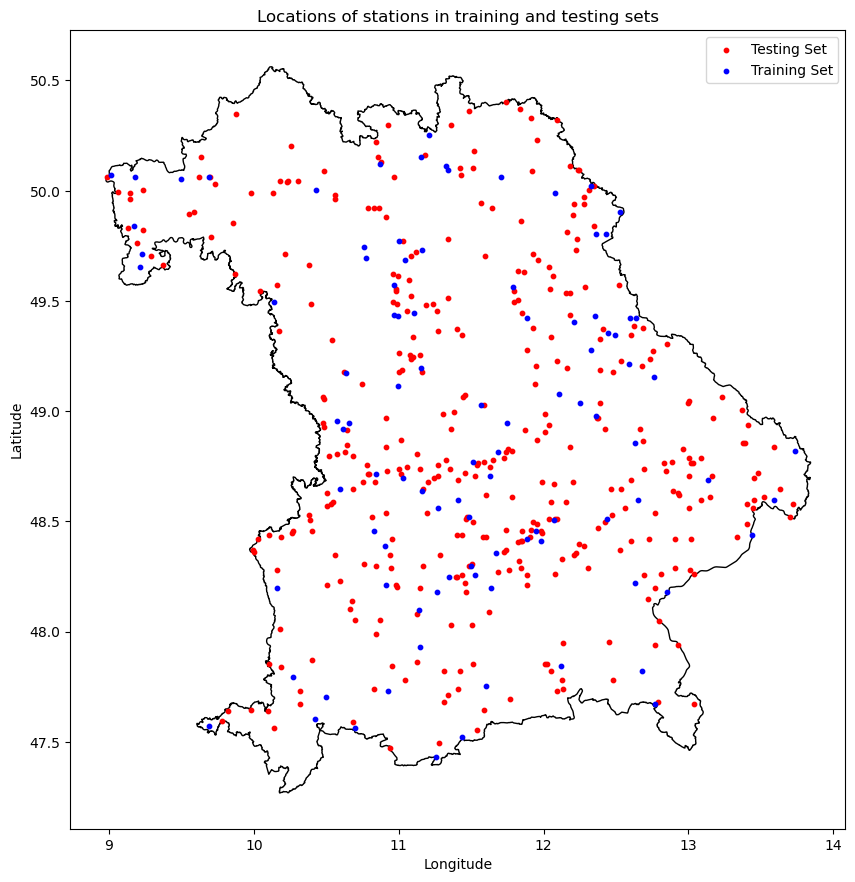

In [85]:
fig, ax = plt.subplots(figsize=(10,12))
bavaria_polygon.plot(ax = ax,color='white', edgecolor='black')
plt.scatter(sorted_df.loc[train_ind,'lon'], sorted_df.loc[train_ind,'lat'], color='red',s=10, label='Testing Set' )
plt.scatter(sorted_df.loc[test_ind,'lon'], sorted_df.loc[test_ind,'lat'], color='blue',s=10, label = 'Training Set' )
plt.title('Locations of stations in training and testing sets')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

## Default models
These are the default models without changing any parameters

In [86]:
y_train_og = sorted_df.iloc[train_ind, 0]
y_test_og = sorted_df.iloc[test_ind, 0]

In [87]:
# model :default, with spatial split, using box cox data


model_default_wss_bc = RandomForestRegressor(random_state = 42)
model_default_wss_bc.fit(X_train, y_train)
y_pred_default_wss_bc = model_default_wss_bc.predict(X_test)
rmse_model_default_wss_bc = np.sqrt(mean_squared_error(y_test_og, inv_boxcox(y_pred_default_wss_bc, lambda_boxcox)))
r2_model_default_wss_bc = r2_score(y_test, y_pred_default_wss_bc)
r_model_default_wss_bc = pearson_corr_coeff(y_test, y_pred_default_wss_bc)
print('RMSE [mg/L], model = default wss bc: ',rmse_model_default_wss_bc)
print('R2, model = default wss bc: ', r2_model_default_wss_bc)
print('R, model = default wss bc: ', r_model_default_wss_bc)

RMSE [mg/L], model = default wss bc:  1.4960285387753383
R2, model = default wss bc:  0.6716715086168172
R, model = default wss bc:  0.8219572773449139


In [114]:
# model: default, NO spatial split, using box cox data

X_nss = scaler.transform(final_df_jan_new.iloc[:, 7:])
y_nss = final_df_jan_new.iloc[:,1]
X_train_nss, X_test_nss, y_train_nss, y_test_nss = train_test_split(X_nss, y_nss, test_size=0.2, random_state=42)
train_ind_nss, test_ind_nss = train_test_split(np.arange(X_nss.shape[0]), test_size=0.2, random_state = 42)

y_test_nss_og = (final_df_jan_new.iloc[test_ind_nss, 0])
y_train_nss_og = (final_df_jan_new.iloc[train_ind_nss, 0])

model_default_nss_bc = RandomForestRegressor(random_state = 42)
model_default_nss_bc.fit(X_train_nss, y_train_nss)
y_pred_default_nss_bc = model_default_nss_bc.predict(X_test_nss)
rmse_model_default_nss_bc = np.sqrt(mean_squared_error(y_test_nss_og, inv_boxcox(y_pred_default_nss_bc, lambda_boxcox)))
r2_model_default_nss_bc = r2_score(y_test_nss, y_pred_default_nss_bc)
r_model_default_nss_bc = pearson_corr_coeff(y_test_nss, y_pred_default_nss_bc)
print('RMSE [mg/L], model = default nss bc: ',rmse_model_default_nss_bc)
print('R2, model = default nss bc: ', r2_model_default_nss_bc)
print('R, model = default nss bc: ', r_model_default_nss_bc)

RMSE [mg/L], model = default nss bc:  1.3729067202202843
R2, model = default nss bc:  0.6353267595753489
R, model = default nss bc:  0.7987386692546457


## Hyperparameter Tuning

In [89]:
# Optimization of model: with spatial split, using box cox transformed data

def objective_opt_wss_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 600)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42)
    scores = cross_val_score(model_tuning, X_train, y_train, cv=5, scoring = "neg_mean_squared_error", n_jobs=24)
    rmse_scores = np.sqrt(np.abs(scores)) 
    mean_score = np.mean(rmse_scores)

    return mean_score
    
    

In [90]:
study_opt_wss_bc =  optuna.create_study(direction = "minimize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-09-05 12:50:44,828] A new study created in memory with name: no-name-ea68cfbd-8d29-4b79-9ee0-48b2ffaad021


In [91]:
study_opt_wss_bc.optimize(objective_opt_wss_bc, n_trials = 500, n_jobs=24)

[I 2024-09-05 12:51:04,829] Trial 1 finished with value: 0.6856198444950459 and parameters: {'n_estimators': 46, 'max_depth': 31, 'min_samples_split': 11, 'min_samples_leaf': 21}. Best is trial 1 with value: 0.6856198444950459.
[I 2024-09-05 12:51:05,891] Trial 0 finished with value: 0.658886913815817 and parameters: {'n_estimators': 40, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.658886913815817.
[I 2024-09-05 12:51:09,451] Trial 16 finished with value: 0.6768569894289888 and parameters: {'n_estimators': 17, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.658886913815817.
[I 2024-09-05 12:51:11,161] Trial 6 finished with value: 0.686602746874106 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.658886913815817.
[I 2024-09-05 12:51:12,011] Trial 10 finished with value: 0.7018996629541827 and parameters: {'n_

[I 2024-09-05 12:51:25,676] Trial 40 finished with value: 0.6673200933015391 and parameters: {'n_estimators': 27, 'max_depth': 15, 'min_samples_split': 27, 'min_samples_leaf': 6}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:26,192] Trial 31 finished with value: 0.6513168835541698 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:26,459] Trial 43 finished with value: 0.7157146668172862 and parameters: {'n_estimators': 3, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:26,788] Trial 35 finished with value: 0.6551094293346085 and parameters: {'n_estimators': 293, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 11}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:27,308] Trial 42 finished with value: 0.6469949934676793 and para

[I 2024-09-05 12:51:51,574] Trial 77 finished with value: 0.8009048825201563 and parameters: {'n_estimators': 12, 'max_depth': 1, 'min_samples_split': 14, 'min_samples_leaf': 24}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:51,729] Trial 70 finished with value: 0.6634202338731837 and parameters: {'n_estimators': 397, 'max_depth': 42, 'min_samples_split': 17, 'min_samples_leaf': 14}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:53,699] Trial 69 finished with value: 0.6423296931171938 and parameters: {'n_estimators': 357, 'max_depth': 39, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:53,847] Trial 80 finished with value: 0.6778375210950955 and parameters: {'n_estimators': 21, 'max_depth': 7, 'min_samples_split': 30, 'min_samples_leaf': 18}. Best is trial 13 with value: 0.6420802407924852.
[I 2024-09-05 12:51:54,091] Trial 73 finished with value: 0.6539446464727819 and p

[I 2024-09-05 12:52:17,655] Trial 108 finished with value: 0.655427548132405 and parameters: {'n_estimators': 244, 'max_depth': 42, 'min_samples_split': 20, 'min_samples_leaf': 11}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:17,862] Trial 105 finished with value: 0.6582522957150546 and parameters: {'n_estimators': 475, 'max_depth': 4, 'min_samples_split': 22, 'min_samples_leaf': 9}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:18,802] Trial 114 finished with value: 0.6592675128041992 and parameters: {'n_estimators': 46, 'max_depth': 46, 'min_samples_split': 27, 'min_samples_leaf': 9}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:19,158] Trial 113 finished with value: 0.7010187081418489 and parameters: {'n_estimators': 184, 'max_depth': 43, 'min_samples_split': 20, 'min_samples_leaf': 25}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:19,324] Trial 109 finished with value: 0.6564599954127648

[I 2024-09-05 12:52:38,644] Trial 148 finished with value: 0.6914672921777656 and parameters: {'n_estimators': 37, 'max_depth': 31, 'min_samples_split': 12, 'min_samples_leaf': 21}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:39,778] Trial 144 finished with value: 0.6957367209643059 and parameters: {'n_estimators': 313, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 24}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:41,016] Trial 145 finished with value: 0.6822422410108147 and parameters: {'n_estimators': 388, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 20}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:41,576] Trial 142 finished with value: 0.6757369186513715 and parameters: {'n_estimators': 521, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 18}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:52:42,425] Trial 152 finished with value: 0.66495812016245

[I 2024-09-05 12:53:04,407] Trial 173 finished with value: 0.6440737507397711 and parameters: {'n_estimators': 582, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:05,308] Trial 181 finished with value: 0.6633972425525562 and parameters: {'n_estimators': 472, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 14}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:06,252] Trial 182 finished with value: 0.6464371652286686 and parameters: {'n_estimators': 212, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:08,887] Trial 186 finished with value: 0.6928674140815632 and parameters: {'n_estimators': 431, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 23}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:09,294] Trial 183 finished with value: 0.6458295285087472 

[I 2024-09-05 12:53:30,736] Trial 220 finished with value: 0.6550294060592521 and parameters: {'n_estimators': 48, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:30,974] Trial 217 finished with value: 0.6794282533291989 and parameters: {'n_estimators': 311, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 19}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:31,542] Trial 216 finished with value: 0.6583934717374631 and parameters: {'n_estimators': 323, 'max_depth': 29, 'min_samples_split': 30, 'min_samples_leaf': 8}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:33,496] Trial 222 finished with value: 0.6503774525768842 and parameters: {'n_estimators': 209, 'max_depth': 27, 'min_samples_split': 22, 'min_samples_leaf': 5}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:53:33,984] Trial 219 finished with value: 0.6722989008302954 

[I 2024-09-05 12:54:00,808] Trial 253 finished with value: 0.6700664687976157 and parameters: {'n_estimators': 527, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:01,176] Trial 257 finished with value: 0.665283256259346 and parameters: {'n_estimators': 47, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 14}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:02,423] Trial 255 finished with value: 0.6853851682857497 and parameters: {'n_estimators': 473, 'max_depth': 24, 'min_samples_split': 13, 'min_samples_leaf': 21}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:02,867] Trial 250 finished with value: 0.6427367361823076 and parameters: {'n_estimators': 589, 'max_depth': 38, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:03,184] Trial 261 finished with value: 0.6857079327472082 

[I 2024-09-05 12:54:28,120] Trial 284 finished with value: 0.6453941949769588 and parameters: {'n_estimators': 415, 'max_depth': 21, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:28,142] Trial 285 finished with value: 0.6460034748099251 and parameters: {'n_estimators': 311, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:28,184] Trial 292 finished with value: 0.7882144104101869 and parameters: {'n_estimators': 335, 'max_depth': 1, 'min_samples_split': 12, 'min_samples_leaf': 22}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:29,395] Trial 295 finished with value: 0.6594591874030116 and parameters: {'n_estimators': 44, 'max_depth': 31, 'min_samples_split': 25, 'min_samples_leaf': 1}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:29,653] Trial 290 finished with value: 0.6500798115329693

[I 2024-09-05 12:54:58,308] Trial 328 finished with value: 0.6457442277534948 and parameters: {'n_estimators': 62, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:58,363] Trial 324 finished with value: 0.6608522380716337 and parameters: {'n_estimators': 473, 'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:58,843] Trial 325 finished with value: 0.6524916980007724 and parameters: {'n_estimators': 162, 'max_depth': 48, 'min_samples_split': 23, 'min_samples_leaf': 1}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:58,925] Trial 330 finished with value: 0.7109399603934093 and parameters: {'n_estimators': 99, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 20}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:54:59,942] Trial 327 finished with value: 0.6785650914480271 

[I 2024-09-05 12:55:26,348] Trial 362 finished with value: 0.6535591524689479 and parameters: {'n_estimators': 93, 'max_depth': 27, 'min_samples_split': 24, 'min_samples_leaf': 7}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:26,627] Trial 363 finished with value: 0.6994679751144707 and parameters: {'n_estimators': 159, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 24}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:27,533] Trial 365 finished with value: 0.656068417928356 and parameters: {'n_estimators': 96, 'max_depth': 11, 'min_samples_split': 27, 'min_samples_leaf': 8}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:28,003] Trial 364 finished with value: 0.6819690151955552 and parameters: {'n_estimators': 203, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 20}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:28,398] Trial 357 finished with value: 0.6428025099373367 

[I 2024-09-05 12:55:55,459] Trial 394 finished with value: 0.6757186891979489 and parameters: {'n_estimators': 590, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 18}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:55,927] Trial 400 finished with value: 0.6784358233952468 and parameters: {'n_estimators': 125, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 19}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:57,011] Trial 397 finished with value: 0.6856698415420404 and parameters: {'n_estimators': 563, 'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 21}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:57,609] Trial 403 finished with value: 0.6836401191454691 and parameters: {'n_estimators': 78, 'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 21}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:55:57,819] Trial 401 finished with value: 0.6731743917434894

[I 2024-09-05 12:56:28,227] Trial 431 finished with value: 0.6492930940643276 and parameters: {'n_estimators': 511, 'max_depth': 44, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:28,517] Trial 435 finished with value: 0.6885760673925264 and parameters: {'n_estimators': 404, 'max_depth': 21, 'min_samples_split': 26, 'min_samples_leaf': 22}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:29,132] Trial 432 finished with value: 0.646314436109704 and parameters: {'n_estimators': 446, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:29,246] Trial 429 finished with value: 0.6550838906364166 and parameters: {'n_estimators': 598, 'max_depth': 47, 'min_samples_split': 29, 'min_samples_leaf': 1}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:30,143] Trial 436 finished with value: 0.655579351788849

[I 2024-09-05 12:56:52,897] Trial 470 finished with value: 0.6609332228816109 and parameters: {'n_estimators': 235, 'max_depth': 44, 'min_samples_split': 24, 'min_samples_leaf': 13}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:52,936] Trial 468 finished with value: 0.651989952025804 and parameters: {'n_estimators': 319, 'max_depth': 24, 'min_samples_split': 24, 'min_samples_leaf': 6}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:53,227] Trial 466 finished with value: 0.6595878586052385 and parameters: {'n_estimators': 455, 'max_depth': 26, 'min_samples_split': 26, 'min_samples_leaf': 12}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:55,955] Trial 477 finished with value: 0.6961620076458586 and parameters: {'n_estimators': 3, 'max_depth': 32, 'min_samples_split': 21, 'min_samples_leaf': 17}. Best is trial 93 with value: 0.6416919416171805.
[I 2024-09-05 12:56:56,068] Trial 471 finished with value: 0.644355642329329

In [92]:
study_opt_wss_bc.best_params

{'n_estimators': 480,
 'max_depth': 49,
 'min_samples_split': 9,
 'min_samples_leaf': 4}

In [93]:
study_opt_wss_bc_best_params = study_opt_wss_bc.best_params

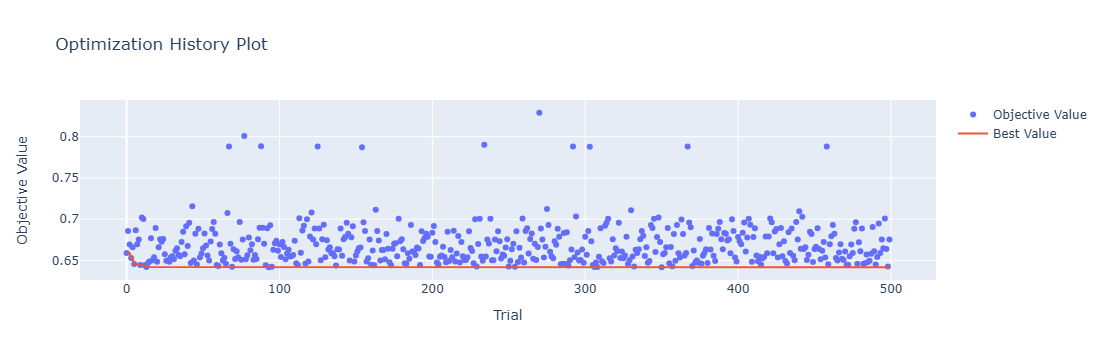

In [94]:
optuna.visualization.plot_optimization_history(study_opt_wss_bc)

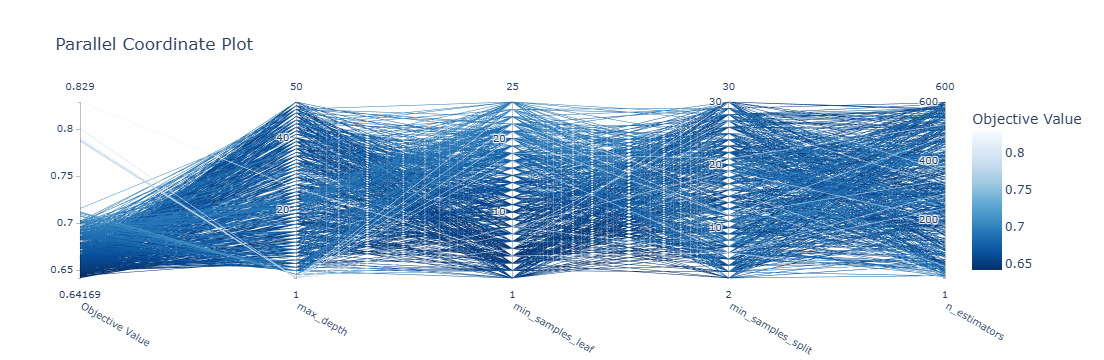

In [95]:
optuna.visualization.plot_parallel_coordinate(study_opt_wss_bc)

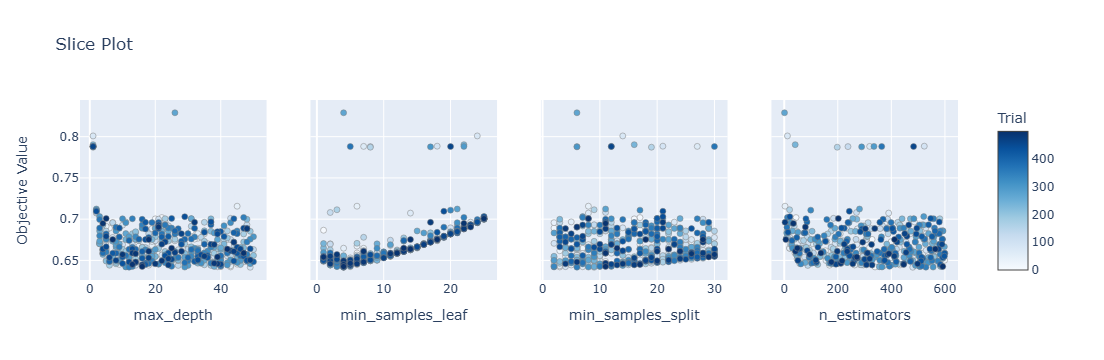

In [96]:
optuna.visualization.plot_slice(study_opt_wss_bc, params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf' ])

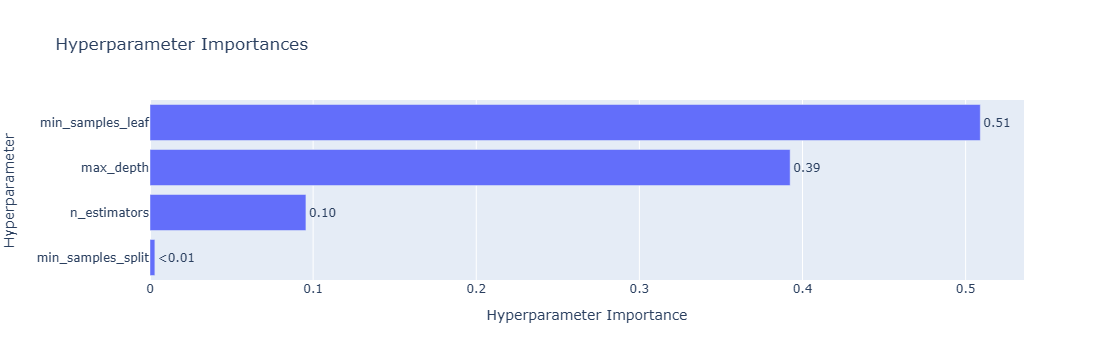

In [97]:
optuna.visualization.plot_param_importances(study_opt_wss_bc)

In [98]:
# Optimization of model: NO spatial split, using box cox data

def objective_opt_nss_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 600)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42)
    scores = cross_val_score(model_tuning, X_train_nss, y_train_nss, cv=5, scoring = "neg_mean_squared_error", n_jobs=24)
    rmse_scores = np.sqrt(np.abs(scores)) 
    mean_score = np.mean(rmse_scores)

    return mean_score

In [99]:
study_opt_nss_bc =  optuna.create_study(direction = "minimize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-09-05 12:57:53,058] A new study created in memory with name: no-name-2e33e4e6-3e9e-4a12-ad0c-ff947e41b4ca


In [100]:
study_opt_nss_bc.optimize(objective_opt_nss_bc, n_trials = 500, n_jobs=24)

[I 2024-09-05 12:57:55,409] Trial 0 finished with value: 0.6685834793678208 and parameters: {'n_estimators': 201, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.6685834793678208.
[I 2024-09-05 12:57:56,027] Trial 2 finished with value: 0.6714256516643514 and parameters: {'n_estimators': 101, 'max_depth': 15, 'min_samples_split': 30, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6685834793678208.
[I 2024-09-05 12:57:57,316] Trial 1 finished with value: 0.6830580906377556 and parameters: {'n_estimators': 457, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.6685834793678208.
[I 2024-09-05 12:58:01,369] Trial 4 finished with value: 0.6750292366353289 and parameters: {'n_estimators': 138, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6685834793678208.
[I 2024-09-05 12:58:02,563] Trial 3 finished with value: 0.6657878285495518 and parameter

[I 2024-09-05 12:58:22,053] Trial 40 finished with value: 0.6816809724643942 and parameters: {'n_estimators': 47, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 19}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:22,770] Trial 41 finished with value: 0.7006373223183591 and parameters: {'n_estimators': 73, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 24}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:24,079] Trial 38 finished with value: 0.6623434205025249 and parameters: {'n_estimators': 344, 'max_depth': 37, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:24,470] Trial 34 finished with value: 0.6667446561789887 and parameters: {'n_estimators': 561, 'max_depth': 37, 'min_samples_split': 23, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:24,524] Trial 43 finished with value: 0.7975062207083998 and para

[I 2024-09-05 12:58:47,158] Trial 75 finished with value: 0.6714523878874159 and parameters: {'n_estimators': 206, 'max_depth': 14, 'min_samples_split': 22, 'min_samples_leaf': 15}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:47,510] Trial 77 finished with value: 0.6700186244716242 and parameters: {'n_estimators': 32, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:48,474] Trial 73 finished with value: 0.6726112284636269 and parameters: {'n_estimators': 443, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 16}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:49,030] Trial 74 finished with value: 0.6752173785115849 and parameters: {'n_estimators': 515, 'max_depth': 43, 'min_samples_split': 15, 'min_samples_leaf': 17}. Best is trial 14 with value: 0.662198645449374.
[I 2024-09-05 12:58:49,711] Trial 72 finished with value: 0.6626346353874311 and par

[I 2024-09-05 12:59:15,782] Trial 108 finished with value: 0.6660854688287045 and parameters: {'n_estimators': 557, 'max_depth': 50, 'min_samples_split': 17, 'min_samples_leaf': 11}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:16,012] Trial 111 finished with value: 0.691256819145987 and parameters: {'n_estimators': 344, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 22}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:16,284] Trial 106 finished with value: 0.6642708918427183 and parameters: {'n_estimators': 547, 'max_depth': 36, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:17,492] Trial 113 finished with value: 0.6710641785193339 and parameters: {'n_estimators': 239, 'max_depth': 38, 'min_samples_split': 16, 'min_samples_leaf': 15}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:17,771] Trial 115 finished with value: 0.7929491435952

[I 2024-09-05 12:59:43,600] Trial 149 finished with value: 0.6958518588317781 and parameters: {'n_estimators': 30, 'max_depth': 46, 'min_samples_split': 21, 'min_samples_leaf': 23}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:43,855] Trial 145 finished with value: 0.7010642034393045 and parameters: {'n_estimators': 349, 'max_depth': 24, 'min_samples_split': 28, 'min_samples_leaf': 25}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:44,477] Trial 140 finished with value: 0.6758062256276938 and parameters: {'n_estimators': 311, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:44,663] Trial 146 finished with value: 0.6666404779108319 and parameters: {'n_estimators': 289, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 11}. Best is trial 81 with value: 0.6621833537522612.
[I 2024-09-05 12:59:46,004] Trial 150 finished with value: 0.6657618748298797

[I 2024-09-05 13:00:09,759] Trial 180 finished with value: 0.6678053673568456 and parameters: {'n_estimators': 271, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 13}. Best is trial 161 with value: 0.6619509781908091.
[I 2024-09-05 13:00:10,621] Trial 181 finished with value: 0.6832495325475515 and parameters: {'n_estimators': 370, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 161 with value: 0.6619509781908091.
[I 2024-09-05 13:00:11,133] Trial 177 finished with value: 0.664462228541386 and parameters: {'n_estimators': 548, 'max_depth': 37, 'min_samples_split': 24, 'min_samples_leaf': 7}. Best is trial 161 with value: 0.6619509781908091.
[I 2024-09-05 13:00:11,267] Trial 185 finished with value: 0.6728026414481697 and parameters: {'n_estimators': 93, 'max_depth': 14, 'min_samples_split': 24, 'min_samples_leaf': 14}. Best is trial 161 with value: 0.6619509781908091.
[I 2024-09-05 13:00:11,721] Trial 186 finished with value: 0.670453620394

[I 2024-09-05 13:00:33,485] Trial 214 finished with value: 0.6667933372406767 and parameters: {'n_estimators': 201, 'max_depth': 25, 'min_samples_split': 27, 'min_samples_leaf': 6}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:00:34,560] Trial 220 finished with value: 0.671371568482982 and parameters: {'n_estimators': 181, 'max_depth': 41, 'min_samples_split': 15, 'min_samples_leaf': 14}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:00:34,631] Trial 215 finished with value: 0.6661357251362853 and parameters: {'n_estimators': 302, 'max_depth': 39, 'min_samples_split': 9, 'min_samples_leaf': 11}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:00:35,318] Trial 222 finished with value: 0.674765634739072 and parameters: {'n_estimators': 93, 'max_depth': 15, 'min_samples_split': 23, 'min_samples_leaf': 16}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:00:38,296] Trial 218 finished with value: 0.662390687669

[I 2024-09-05 13:00:58,473] Trial 252 finished with value: 0.6684398228644948 and parameters: {'n_estimators': 363, 'max_depth': 39, 'min_samples_split': 28, 'min_samples_leaf': 12}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:00:59,158] Trial 253 finished with value: 0.6647191597967927 and parameters: {'n_estimators': 240, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:00:59,417] Trial 256 finished with value: 0.6655432563000019 and parameters: {'n_estimators': 119, 'max_depth': 11, 'min_samples_split': 24, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:00,676] Trial 259 finished with value: 0.6787399466274264 and parameters: {'n_estimators': 84, 'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 18}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:00,781] Trial 254 finished with value: 0.687026742518

[I 2024-09-05 13:01:23,948] Trial 287 finished with value: 0.6830649584916111 and parameters: {'n_estimators': 350, 'max_depth': 45, 'min_samples_split': 16, 'min_samples_leaf': 20}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:24,251] Trial 288 finished with value: 0.6664342392139069 and parameters: {'n_estimators': 210, 'max_depth': 32, 'min_samples_split': 26, 'min_samples_leaf': 9}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:24,347] Trial 291 finished with value: 0.6684843419779518 and parameters: {'n_estimators': 83, 'max_depth': 8, 'min_samples_split': 29, 'min_samples_leaf': 6}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:24,516] Trial 289 finished with value: 0.6682675922021561 and parameters: {'n_estimators': 226, 'max_depth': 32, 'min_samples_split': 18, 'min_samples_leaf': 12}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:24,599] Trial 295 finished with value: 0.66451356677

[I 2024-09-05 13:01:48,464] Trial 326 finished with value: 0.6745298243788062 and parameters: {'n_estimators': 252, 'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 17}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:48,492] Trial 323 finished with value: 0.6746452192354189 and parameters: {'n_estimators': 370, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 17}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:48,976] Trial 328 finished with value: 0.6762383484983173 and parameters: {'n_estimators': 115, 'max_depth': 31, 'min_samples_split': 20, 'min_samples_leaf': 17}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:49,287] Trial 325 finished with value: 0.6773419983945334 and parameters: {'n_estimators': 394, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 18}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:01:49,362] Trial 322 finished with value: 0.68705446

[I 2024-09-05 13:02:09,490] Trial 359 finished with value: 0.665394998006939 and parameters: {'n_estimators': 234, 'max_depth': 44, 'min_samples_split': 27, 'min_samples_leaf': 3}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:02:10,220] Trial 364 finished with value: 0.6653807415645036 and parameters: {'n_estimators': 83, 'max_depth': 48, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:02:10,493] Trial 362 finished with value: 0.6723640008074883 and parameters: {'n_estimators': 311, 'max_depth': 28, 'min_samples_split': 25, 'min_samples_leaf': 16}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:02:10,846] Trial 366 finished with value: 0.6643071415630937 and parameters: {'n_estimators': 63, 'max_depth': 48, 'min_samples_split': 25, 'min_samples_leaf': 6}. Best is trial 194 with value: 0.6619353952594466.
[I 2024-09-05 13:02:11,708] Trial 365 finished with value: 0.6757985757149

[I 2024-09-05 13:02:37,872] Trial 397 finished with value: 0.6641688777784864 and parameters: {'n_estimators': 219, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:02:38,878] Trial 400 finished with value: 0.6688271734680746 and parameters: {'n_estimators': 184, 'max_depth': 43, 'min_samples_split': 19, 'min_samples_leaf': 13}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:02:38,946] Trial 392 finished with value: 0.662015737166626 and parameters: {'n_estimators': 570, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:02:39,349] Trial 398 finished with value: 0.6904684291718219 and parameters: {'n_estimators': 409, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 22}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:02:40,791] Trial 401 finished with value: 0.676417077427

[I 2024-09-05 13:03:05,869] Trial 434 finished with value: 0.6670034325561508 and parameters: {'n_estimators': 285, 'max_depth': 29, 'min_samples_split': 23, 'min_samples_leaf': 12}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:06,965] Trial 432 finished with value: 0.6631495643766732 and parameters: {'n_estimators': 558, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:07,190] Trial 437 finished with value: 0.6848170753555988 and parameters: {'n_estimators': 142, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 20}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:07,634] Trial 435 finished with value: 0.6652987965983126 and parameters: {'n_estimators': 286, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:08,232] Trial 438 finished with value: 0.676594805680

[I 2024-09-05 13:03:34,013] Trial 466 finished with value: 0.6624206181750949 and parameters: {'n_estimators': 520, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:34,089] Trial 472 finished with value: 0.6693396581581299 and parameters: {'n_estimators': 76, 'max_depth': 30, 'min_samples_split': 14, 'min_samples_leaf': 11}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:34,494] Trial 473 finished with value: 0.6734300656521696 and parameters: {'n_estimators': 79, 'max_depth': 30, 'min_samples_split': 28, 'min_samples_leaf': 14}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:35,500] Trial 467 finished with value: 0.6636322358208593 and parameters: {'n_estimators': 557, 'max_depth': 46, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 374 with value: 0.6612559249040999.
[I 2024-09-05 13:03:35,827] Trial 476 finished with value: 0.678599717523

In [101]:
study_opt_nss_bc.best_params

{'n_estimators': 32,
 'max_depth': 48,
 'min_samples_split': 24,
 'min_samples_leaf': 9}

In [102]:
study_opt_nss_bc_best_params = study_opt_nss_bc.best_params

## Fitting and testing model with best parameters


In [103]:
# with spatial split, box cox data

best_n_estimators_opt_wss_bc = study_opt_wss_bc_best_params['n_estimators']
best_max_depth_opt_wss_bc = study_opt_wss_bc_best_params['max_depth']
best_min_samples_split_opt_wss_bc = study_opt_wss_bc_best_params['min_samples_split']
best_min_samples_leaf_opt_wss_bc = study_opt_wss_bc_best_params['min_samples_leaf']

best_model_opt_wss_bc = RandomForestRegressor(n_estimators = best_n_estimators_opt_wss_bc, max_depth = best_max_depth_opt_wss_bc , 
                                              min_samples_split= best_min_samples_split_opt_wss_bc, 
                                              min_samples_leaf=best_min_samples_leaf_opt_wss_bc, random_state=42)

best_model_opt_wss_bc.fit(X_train, y_train)

y_pred_opt_wss_bc = best_model_opt_wss_bc.predict(X_test)

rmse_model_opt_wss_bc = np.sqrt(mean_squared_error(y_test_og, inv_boxcox(y_pred_opt_wss_bc, lambda_boxcox)))
r2_model_opt_wss_bc = r2_score(y_test, y_pred_opt_wss_bc)
r_model_opt_wss_bc = pearson_corr_coeff(y_test, y_pred_opt_wss_bc)


print('RMSE [mg/L], model = opt wss bc: ',rmse_model_opt_wss_bc)
print('R2, model = opt wss bc: ', r2_model_opt_wss_bc)
print('R, model = opt wss bc: ', r_model_opt_wss_bc)

RMSE [mg/L], model = opt wss bc:  1.4963005173254655
R2, model = opt wss bc:  0.6750951739960885
R, model = opt wss bc:  0.8256155981277892


In [104]:
# NO spatial split, box cox data

best_n_estimators_opt_nss_bc = study_opt_nss_bc_best_params['n_estimators']
best_max_depth_opt_nss_bc = study_opt_nss_bc_best_params['max_depth']
best_min_samples_split_opt_nss_bc = study_opt_nss_bc_best_params['min_samples_split']
best_min_samples_leaf_opt_nss_bc = study_opt_nss_bc_best_params['min_samples_leaf']

best_model_opt_nss_bc = RandomForestRegressor(n_estimators = best_n_estimators_opt_nss_bc, max_depth = best_max_depth_opt_nss_bc , 
                                              min_samples_split= best_min_samples_split_opt_nss_bc, 
                                              min_samples_leaf=best_min_samples_leaf_opt_nss_bc, random_state=42)

best_model_opt_nss_bc.fit(X_train_nss, y_train_nss)

y_pred_opt_nss_bc = best_model_opt_nss_bc.predict(X_test_nss)

rmse_model_opt_nss_bc = np.sqrt(mean_squared_error(y_test_nss_og, inv_boxcox(y_pred_opt_nss_bc, lambda_boxcox)))
r2_model_opt_nss_bc = r2_score(y_test_nss, y_pred_opt_nss_bc)
r_model_opt_nss_bc = pearson_corr_coeff(y_test_nss, y_pred_opt_nss_bc)

print('RMSE [mg/L], model = opt nss bc: ',rmse_model_opt_nss_bc)
print('R2, model = opt nss bc: ', r2_model_opt_nss_bc)
print('R, model = opt nss bc: ', r_model_opt_nss_bc)

RMSE [mg/L], model = opt nss bc:  1.348321852324703
R2, model = opt nss bc:  0.6453086598665858
R, model = opt nss bc:  0.8081746482497255


## Plot figures

Text(0.5, 1.08, 'Correlation Plot for Default Model (using Spatial Split)')

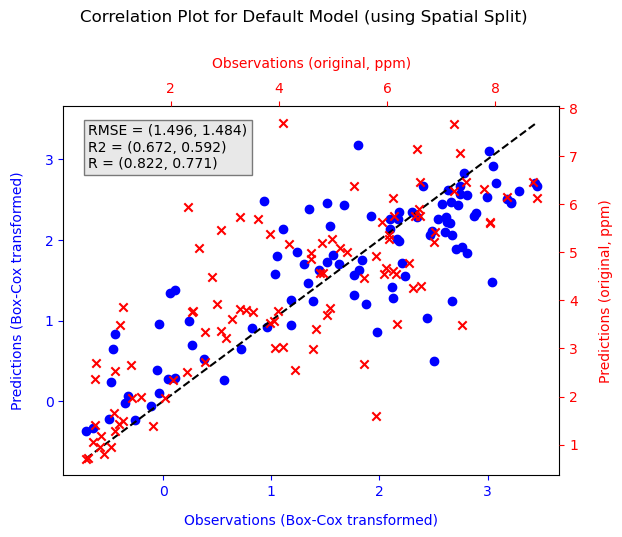

In [105]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax1.scatter(y_test, y_pred_default_wss_bc, marker = 'o', color ='blue')
ax1.set_xlabel('Observations (Box-Cox transformed)', color = 'blue')
ax1.set_ylabel('Predictions (Box-Cox transformed)', color = 'blue')
ax1.tick_params(axis = 'x', color = 'blue', labelcolor = 'blue')
ax1.tick_params(axis = 'y', color = 'blue', labelcolor = 'blue')
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 10

props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)

textstr = '\n'.join((
    r'RMSE = ({}, {})'.format(np.round(rmse_model_default_wss_bc,3), np.round(rmse_model_default_wss_og,3)),
    r'R2 = ({}, {})'.format(np.round(r2_model_default_wss_bc, 3), np.round(r2_model_default_wss_og,3)),
    r'R = ({}, {})'.format(np.round(r_model_default_wss_bc, 3), np.round(r_model_default_wss_og, 3))))

ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

min_ax1 = min(y_test)
max_ax1 = max(y_test)
ax1.plot([min_ax1, max_ax1], [min_ax1, max_ax1], linestyle = 'dashed', color = 'black')


ax2.scatter(y_test_og, y_pred_default_wss_og, marker = 'x', color ='red')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Observations (original, ppm)', color = 'red')
ax2.set_ylabel('Predictions (original, ppm)', color = 'red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis = 'x', color = 'red', labelcolor = 'red')
ax2.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 10

fig.suptitle('Correlation Plot for Default Model (using Spatial Split)', y = 1.08)

Text(0.5, 1.08, 'Correlation Plot for Optimzed Model (using Spatial Split)')

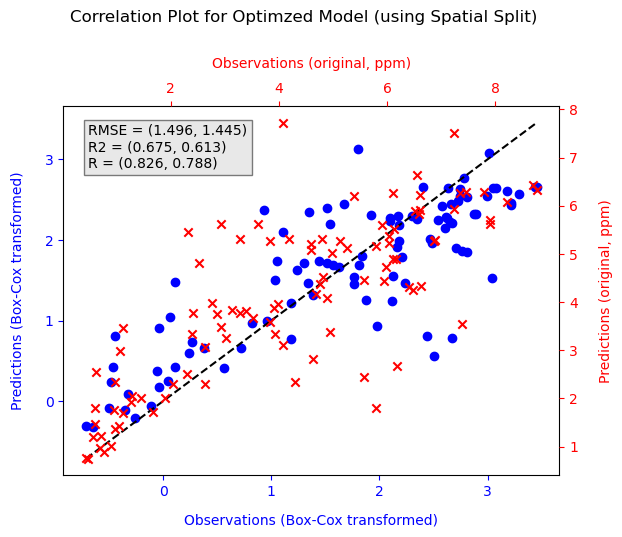

In [106]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax1.scatter(y_test, y_pred_opt_wss_bc, marker = 'o', color ='blue')
ax1.set_xlabel('Observations (Box-Cox transformed)', color = 'blue')
ax1.set_ylabel('Predictions (Box-Cox transformed)', color = 'blue')
ax1.tick_params(axis = 'x', color = 'blue', labelcolor = 'blue')
ax1.tick_params(axis = 'y', color = 'blue', labelcolor = 'blue')
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 10

props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)

textstr = '\n'.join((
    r'RMSE = ({}, {})'.format(np.round(rmse_model_opt_wss_bc,3), np.round(rmse_model_opt_wss_og,3)),
    r'R2 = ({}, {})'.format(np.round(r2_model_opt_wss_bc, 3), np.round(r2_model_opt_wss_og,3)),
    r'R = ({}, {})'.format(np.round(r_model_opt_wss_bc, 3), np.round(r_model_opt_wss_og, 3))))

ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

min_ax1 = min(y_test)
max_ax1 = max(y_test)
ax1.plot([min_ax1, max_ax1], [min_ax1, max_ax1], linestyle = 'dashed', color = 'black')


ax2.scatter(y_test_og, y_pred_opt_wss_og, marker = 'x', color ='red')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Observations (original, ppm)', color = 'red')
ax2.set_ylabel('Predictions (original, ppm)', color = 'red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis = 'x', color = 'red', labelcolor = 'red')
ax2.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 10

fig.suptitle('Correlation Plot for Optimzed Model (using Spatial Split)', y = 1.08)

## Feature Importance

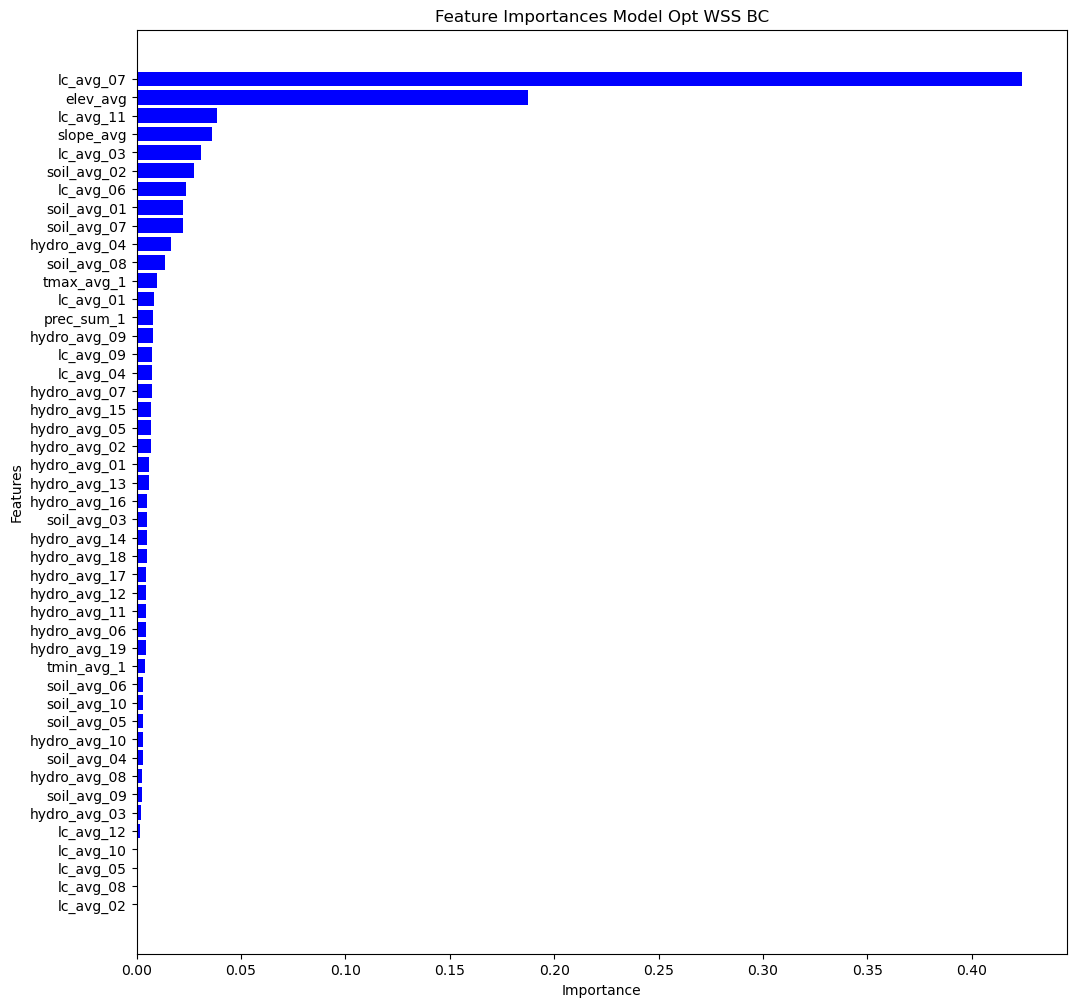

In [107]:
feature_importances_opt_wss_bc = best_model_opt_wss_bc.feature_importances_

indices = np.argsort(feature_importances_opt_wss_bc)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Opt WSS BC')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_opt_wss_bc[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [final_df_jan_new.columns[7:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')

# Show the plot
plt.show()

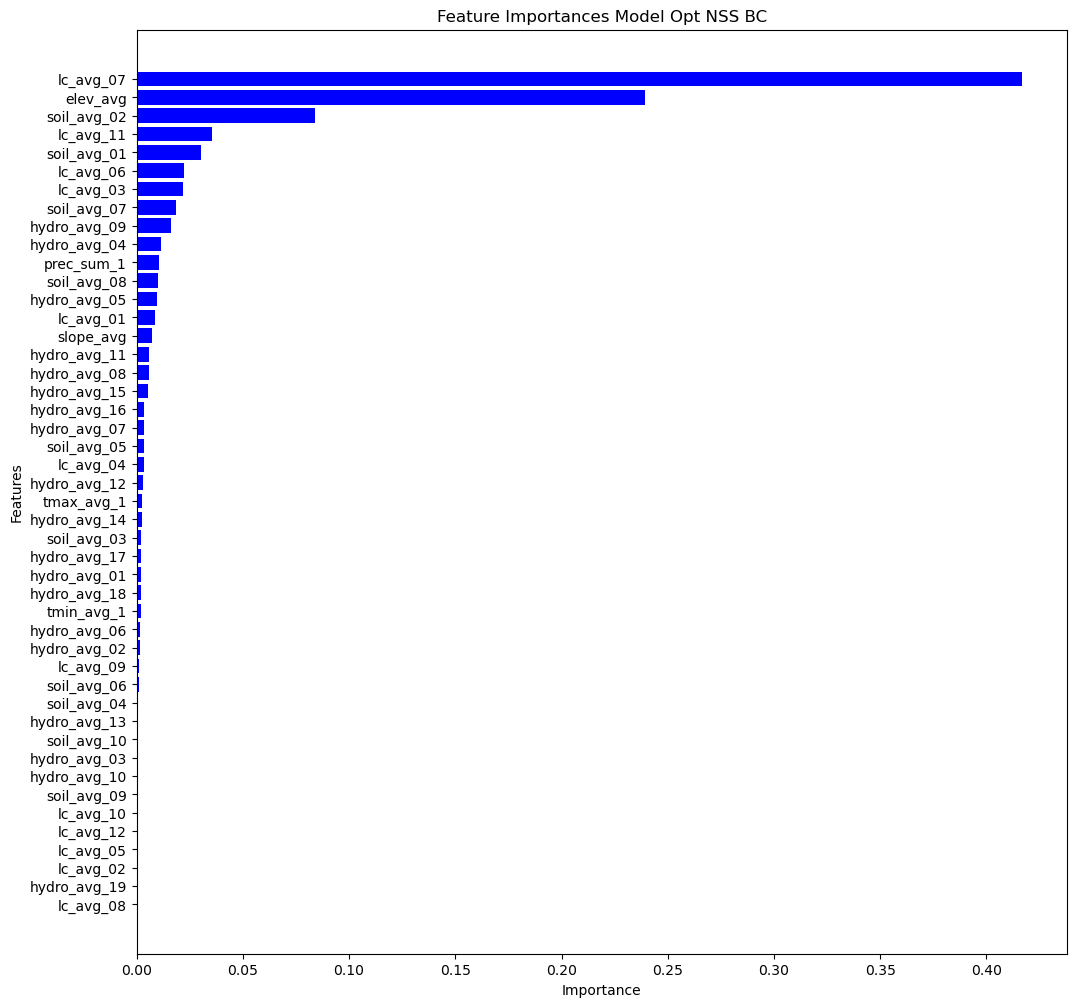

In [108]:
feature_importances_opt_nss_bc = best_model_opt_nss_bc.feature_importances_

indices = np.argsort(feature_importances_opt_nss_bc)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Opt NSS BC')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_opt_nss_bc[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [final_df_jan_new.columns[7:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')

# Show the plot
plt.show()

In [109]:
np.sum(np.sort(feature_importances_opt_wss_bc*100))

100.00000000000001

In [110]:
np.sort(feature_importances_opt_nss_bc*100)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.17198664e-02, 2.41059477e-02,
       4.39548682e-02, 4.68105673e-02, 8.10334118e-02, 8.35964821e-02,
       9.25790987e-02, 1.31333692e-01, 1.34653837e-01, 1.67327980e-01,
       1.94773862e-01, 2.04054817e-01, 2.09306468e-01, 2.10130641e-01,
       2.21946084e-01, 2.55132915e-01, 2.68717185e-01, 3.19973691e-01,
       3.23503845e-01, 3.29487122e-01, 3.40591766e-01, 3.57840636e-01,
       5.37307440e-01, 5.64631520e-01, 5.93577580e-01, 7.14618448e-01,
       8.45306562e-01, 9.37035533e-01, 1.02334002e+00, 1.05301036e+00,
       1.13887482e+00, 1.63925847e+00, 1.84092070e+00, 2.19389539e+00,
       2.24948936e+00, 3.04263154e+00, 3.56044412e+00, 8.41754815e+00,
       2.39048895e+01, 4.16906457e+01])

In [111]:
features_filtered = [final_df_jan_new.iloc[:,7:].columns[i] for i in range(len(feature_importances_opt_wss_bc)) if feature_importances_opt_wss_bc[i] > 0.01 ]

In [112]:
features_filtered_nss = [final_df_jan_new.iloc[:,7:].columns[i] for i in range(len(feature_importances_opt_nss_bc)) if feature_importances_opt_nss_bc[i] > 0.01 ]
print(features_filtered_nss)

['elev_avg', 'lc_avg_03', 'lc_avg_06', 'lc_avg_07', 'lc_avg_11', 'hydro_avg_04', 'hydro_avg_09', 'soil_avg_01', 'soil_avg_02', 'soil_avg_07', 'soil_avg_08', 'prec_sum_1']


In [115]:
# Save required information to disk
month = '_jan'

variables2save = [X_train, X_test, y_train, y_test, y_train_og, y_test_og,
                  train_ind, test_ind, sorted_df,
                  rmse_model_default_wss_bc, r2_model_default_wss_bc, r_model_default_wss_bc,
                  y_pred_default_wss_bc,
                  rmse_model_opt_wss_bc, r2_model_opt_wss_bc, r_model_opt_wss_bc,
                  study_opt_wss_bc,
                  study_opt_wss_bc_best_params,
                  feature_importances_opt_wss_bc,
                  y_pred_opt_wss_bc,
                 X_train_nss, X_test_nss, y_train_nss, y_test_nss,y_train_nss_og, y_test_nss_og,
                  train_ind_nss, test_ind_nss,
                 rmse_model_default_nss_bc, r2_model_default_nss_bc, r_model_default_nss_bc,
                  y_pred_default_nss_bc,
                  rmse_model_opt_nss_bc, r2_model_opt_nss_bc, r_model_opt_nss_bc,
                  study_opt_nss_bc,
                  study_opt_nss_bc_best_params,
                  feature_importances_opt_nss_bc,
                  y_pred_opt_nss_bc]

variables_name = ['X_train', 'X_test', 'y_train', 'y_test', 'y_train_og', 'y_test_og',
                  'train_ind_wss', 'test_ind_wss', 'sorted_df',
                  'rmse_model_default_wss_bc', 'r2_model_default_wss_bc', 'r_model_default_wss_bc',
                  'y_pred_default_wss_bc',
                  'rmse_model_opt_wss_bc', 'r2_model_opt_wss_bc', 'r_model_opt_wss_bc',
                  'study_opt_wss_bc',
                  'study_opt_wss_bc_best_params', 
                  'feature_importances_opt_wss_bc',
                  'y_pred_opt_wss_bc',
                 'X_train_nss', 'X_test_nss', 'y_train_nss', 'y_test_nss','y_train_nss_og', 'y_test_nss_og',
                  'train_ind_nss', 'test_ind_nss',
                 'rmse_model_default_nss_bc', 'r2_model_default_nss_bc', 'r_model_default_nss_bc',
                  'y_pred_default_nss_bc',
                  'rmse_model_opt_nss_bc', 'r2_model_opt_nss_bc', 'r_model_opt_nss_bc',
                  'study_opt_nss_bc',
                  'study_opt_nss_bc_best_params', 
                  'feature_importances_opt_nss_bc',
                  'y_pred_opt_nss_bc']

variables_save_name = [i+month for i in variables_name]

for i in range(len(variables2save)):
    # save the variables
    filepath = variables_save_name[i]
    with open(filepath, 'wb') as file:
        pickle.dump(variables2save[i], file)